Models:
- Simcse
- DirectCSE
- BYOLSE
- DirectBYOLSE

Import things → Choose one model to init → jump to Training

In [1]:
import sys
import matplotlib.pyplot as plt
## path to text contrastive learning library
PATH_TO_COTRALIB = '/textContraLib'
sys.path.insert(0, PATH_TO_COTRALIB)
from models import *
from trainers import *

***

## Model init

### -  SimCSE

In [2]:
config = BertConfig()
model = SimCSEModel(config)

In [3]:
## load weights from pretrained BERT
## save from bert first to get these weights
model.embedding.load_state_dict(torch.load('bert-base-uncased-weights\\embeddings.pth'))
model.encoder.load_state_dict(torch.load('bert-base-uncased-weights\\encoder.pth'))
model.projector.dense.load_state_dict(torch.load('bert-base-uncased-weights\\pooler_dense.pth'))

<All keys matched successfully>

### - DirectCSE

In [7]:
config = BertConfig()
config.cut_dim = 200 # DirectCSEModel需要

In [8]:
model = DirectCSEModel(config)

In [10]:
model.embedding.load_state_dict(torch.load('bert-base-uncased-weights\\embeddings.pth'))
model.encoder.load_state_dict(torch.load('bert-base-uncased-weights\\encoder.pth'))

<All keys matched successfully>

### - BYOLSE

In [14]:
config = BertConfig()
config.decay = 0.85    # BYOLSEModel需要
model = BYOLSEModel(config)

In [15]:
# online init
model.online_embedding.load_state_dict(torch.load('bert-base-uncased-weights\\embeddings.pth'))
model.online_encoder.load_state_dict(torch.load('bert-base-uncased-weights\\encoder.pth'))
model.online_projector.dense.load_state_dict(torch.load('bert-base-uncased-weights\\pooler_dense.pth'))
# target init
model.prepare()

In [16]:
non_optimizer_list = [model.target_embedding,model.target_encoder, model.target_projector]
for layer in non_optimizer_list:
    for para in layer.parameters():
        para.requires_grad = False

### - DirectBYOLSE

In [20]:
config = BertConfig()
config.cut_dim = 200 # DirectCSEModel需要
config.decay = 0.85    # BYOLSEModel需要
model = DirectBYOLSEModel(config)

In [22]:
# online init
model.online_embedding.load_state_dict(torch.load('bert-base-uncased-weights\\embeddings.pth'))
model.online_encoder.load_state_dict(torch.load('bert-base-uncased-weights\\encoder.pth'))
# target init
model.prepare()

In [24]:
non_optimizer_list = [model.target_embedding,model.target_encoder]
for layer in non_optimizer_list:
    for para in layer.parameters():
        para.requires_grad = False

***

## Training

In [25]:
model = model.cuda()

In [26]:
# trainer 参数
args = TrainingArguments(
    output_dir = 'test', #记得改输出文件夹
    evaluation_strategy   = "steps",
    eval_steps            = 5,
    learning_rate         = 3e-5,
    num_train_epochs      = 1.0,
    weight_decay          = 1e-6,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size  = 64,
)
trainer = SimCSETrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [27]:
trainer.train()

***** Running training *****
  Num examples = 995447
  Num Epochs = 1
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 15554


Step,Training Loss,Validation Loss


+--------------+-----------------+-------+
| STSBenchmark | SICKRelatedness |  Avg. |
+--------------+-----------------+-------+
|    36.06     |      46.33      | 41.20 |
+--------------+-----------------+-------+


Saving model checkpoint to test\best-model
Configuration saved in test\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 24.51 | 35.26 | 24.09 | 41.62 | 47.43 |    23.32     |      43.42      | 34.24 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in test\best-model\pytorch_model.bin
tokenizer config file saved in test\best-model\tokenizer_config.json
Special tokens file saved in test\best-model\special_tokens_map.json


corr before pooler: 41.196666666666665 
 max corr  41.196666666666665
+--------------+-----------------+-------+
| STSBenchmark | SICKRelatedness |  Avg. |
+--------------+-----------------+-------+
|    39.32     |      47.01      | 43.16 |
+--------------+-----------------+-------+


Saving model checkpoint to test\best-model
Configuration saved in test\best-model\config.json


+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| STS12 | STS13 | STS14 | STS15 | STS16 | STSBenchmark | SICKRelatedness |  Avg. |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+
| 24.48 | 35.89 | 25.46 | 44.50 | 49.33 |    24.96     |      44.57      | 35.60 |
+-------+-------+-------+-------+-------+--------------+-----------------+-------+


Model weights saved in test\best-model\pytorch_model.bin
tokenizer config file saved in test\best-model\tokenizer_config.json
Special tokens file saved in test\best-model\special_tokens_map.json


corr before pooler: 43.163333333333334 
 max corr  43.163333333333334
+--------------+-----------------+-------+
| STSBenchmark | SICKRelatedness |  Avg. |
+--------------+-----------------+-------+
|    41.72     |      46.62      | 44.17 |
+--------------+-----------------+-------+


KeyboardInterrupt: 

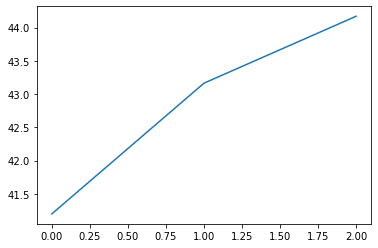

In [28]:
plt.plot(trainer.corr_record)